In [2]:
#import lib พื้นฐานที่จำเป็น
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore") # เอาไว้ ลบwarning 

In [3]:
#import dataset และ print เช็คข้อมูล
data = pd.read_csv("data.csv")
data.head()

,Id,Title,Body,Tags,CreationDate,Y
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE
1,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ
2,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ
3,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ
4,34553755,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,2016-01-01 05:21:48,HQ


In [4]:
#ตัด feature ใน dataset ที่ไม่จำเป็นออกไป
data = data.drop(['Id' , 'Tags' , 'CreationDate'],axis=1) # ลบ feature ที่ไม่สำคัญออกไป
data['Y'] = data['Y'].map({'LQ_CLOSE':0,'LQ_EDIT':1,'HQ':2}) # encoded target class ใหม่ให้กลายเป็นตัวเลข ตามลำดับ

data.head()

,Title,Body,Y
0,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,0
1,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,2
2,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,2
3,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",2
4,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,2


In [5]:
data['text'] = data['Title'] + ' ' + data['Body'] # รวม Title และ Body เข้าด้วยกันเพื่อเตรียมไปใส่ในmodel และเปลี่ยนชื่อเป็น text
data = data.drop(['Title','Body'],axis=1) # ทิ้งอันเดิม ออก
data.head()

,Y,text
0,0,Java: Repeat Task Every Random Seconds <p>I'm ...
1,2,Why are Java Optionals immutable? <p>I'd like ...
2,2,Text Overlay Image with Darkened Opacity React...
3,2,Why ternary operator in swift is so picky? <p>...
4,2,hide/show fab with scale animation <p>I'm usin...


In [6]:
import re # import regularexpression
def clean(text): # ฟังก์ชั่น ลบเครื่องหมายต่างๆ ที่ไม่ใช่text ออก เช่น? <> โดยใช้ regular expression
    text = text.lower() # เปลี่ยนให้เป็น lower case
    text = re.sub(r'[^(a-zA-Z)\s]','',text)
    return text

In [7]:
data['text'] = data['text'].apply(clean) # เรียกใช้ ฟังก์ชั่น clean

data.head()

,Y,text
0,0,java repeat task every random seconds pim alre...
1,2,why are java optionals immutable pid like to u...
2,2,text overlay image with darkened opacity react...
3,2,why ternary operator in swift is so picky pthe...
4,2,hideshow fab with scale animation pim using cu...


### สร้างvector ของข้อมูล โดยเลือกใช้ CountVectorizer

In [8]:
from sklearn.feature_extraction.text import CountVectorizer # import Countvectorrizer
X = data['text'].values # แยก feature กับ target class ออกจากกัน
y = data['Y'].values

max_feat = 20000 # ตอนทำ vector อาจเกิด memory error เนื่องจาก data มี dimension มากเกิน จึงต้องลดลงตามความเหมาะสม (สามารถปรับได้)

vectorizer = CountVectorizer(lowercase=False,max_features=max_feat)
X_trans = vectorizer.fit_transform(X).toarray() # ทำการใช้ countvectorizer กับ feature x เพื่อเปลี่ยนเป็นตัวเลข

In [9]:
#แบ่งข้อมูลสำหรับนำเข้าไปใส่ใน model
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_trans, y, test_size=0.3, random_state=42) # แบ่งเป็น 80/20

In [10]:
print(X_train_cv.shape) # เอาไว้เช็ค shape ของ ข้อมูล train

(31500, 20000)


### สร้าง DNW MODEL 

In [11]:
#import lib ที่จำเป็น
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

In [12]:
model = Sequential()
model.add(Dense(units=10, activation='relu', input_dim=X_trans.shape[1]))
model.add(Dropout(0.5))  # เพิ่ม dropout เพื่อเป็นการลด overfit เบื้องต้น
model.add(Dense(units=3, activation='softmax')) #output layer มี 3 units ตามจำวน target class และใช้ softmax ที่เหมาะกับการทำ classification ที่มีหลายคลาสมากกว่า

ในการสร้าง model เราสร้าง fullyconnected ด้วย 10 layers (ซึ่งเป็นตัวเลขที่กลางๆ เพราะถ้าใส่มากกว่านี้อาจจะทำให้model ซับซ้อนมากเกินไป) โดยเราจะใส่ dropout rate ที่50% เพื่อเป็นการให้model ไม่จำ pattern เดิมๆระหว่าง train 

ส่วนของ output layer เราจะoutput ออกแค่ 3 ตัวตามจำนวน target class และใช้ softmax ที่เหมาะกับการใช้ร่วมกับ muticlassification มากกว่า


In [13]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

loss = sparse_categorical_crossentropy = เอาไว้ใช้กับกรณี muticlassification (dataset ตัวนี้มี target 3 ตัว) ที่จะคำนวณค่าต่างๆออกมาเป็น ความน่าจะเป็นต่างๆแล้วนำไปเปรียบเทียบกับ กับค่าที่เป็น true

metric = accuracy = เป็นคะแนนที่เอาไว้บอกว่า model มีความสามารถในการ predict ออกมาได้ตรงมากขนาดไหน

adam = ใส่ไว้เป็นตัวลด loss เวลาที่ model กำลัง train อยู่

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                200010    
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 33        
                                                                 
Total params: 200043 (781.42 KB)
Trainable params: 200043 (781.42 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


โดย shape ของ X_train_cv เราจะ เป็น (36000,35000)

layers ที่1 (fully conected) จะคำนวณจำนวน parameter ทั้งหมดออกมาได้แบบนี้

input_dim (จำนวน node ของ input) = 35000
units (จำนวน neurons)= 10
สูตรคำนวณคือ (input+1) * units = 35001 * 10 = 350010 parameters (รวมทั้ง weights และ biases)

layer ที่ 2 (dropout) 

เอาไว้ drop activation บางตัวใน layer ที่ 1 ให้เป็น0 เพื่อไม่ให้ model จดจำpattern การเรียนรู้แบบเดิมๆไปตลอด

layer ที่ 3 (output) คำนวนออกมาเหมือนกับ layer ที่1 คือ 

(input+1) * units = 11*3 = 33 parameters (รวมทั้ง weights และ biases)



### รูปภาพ สถาปัตยกรรมของ model ตัวนี้


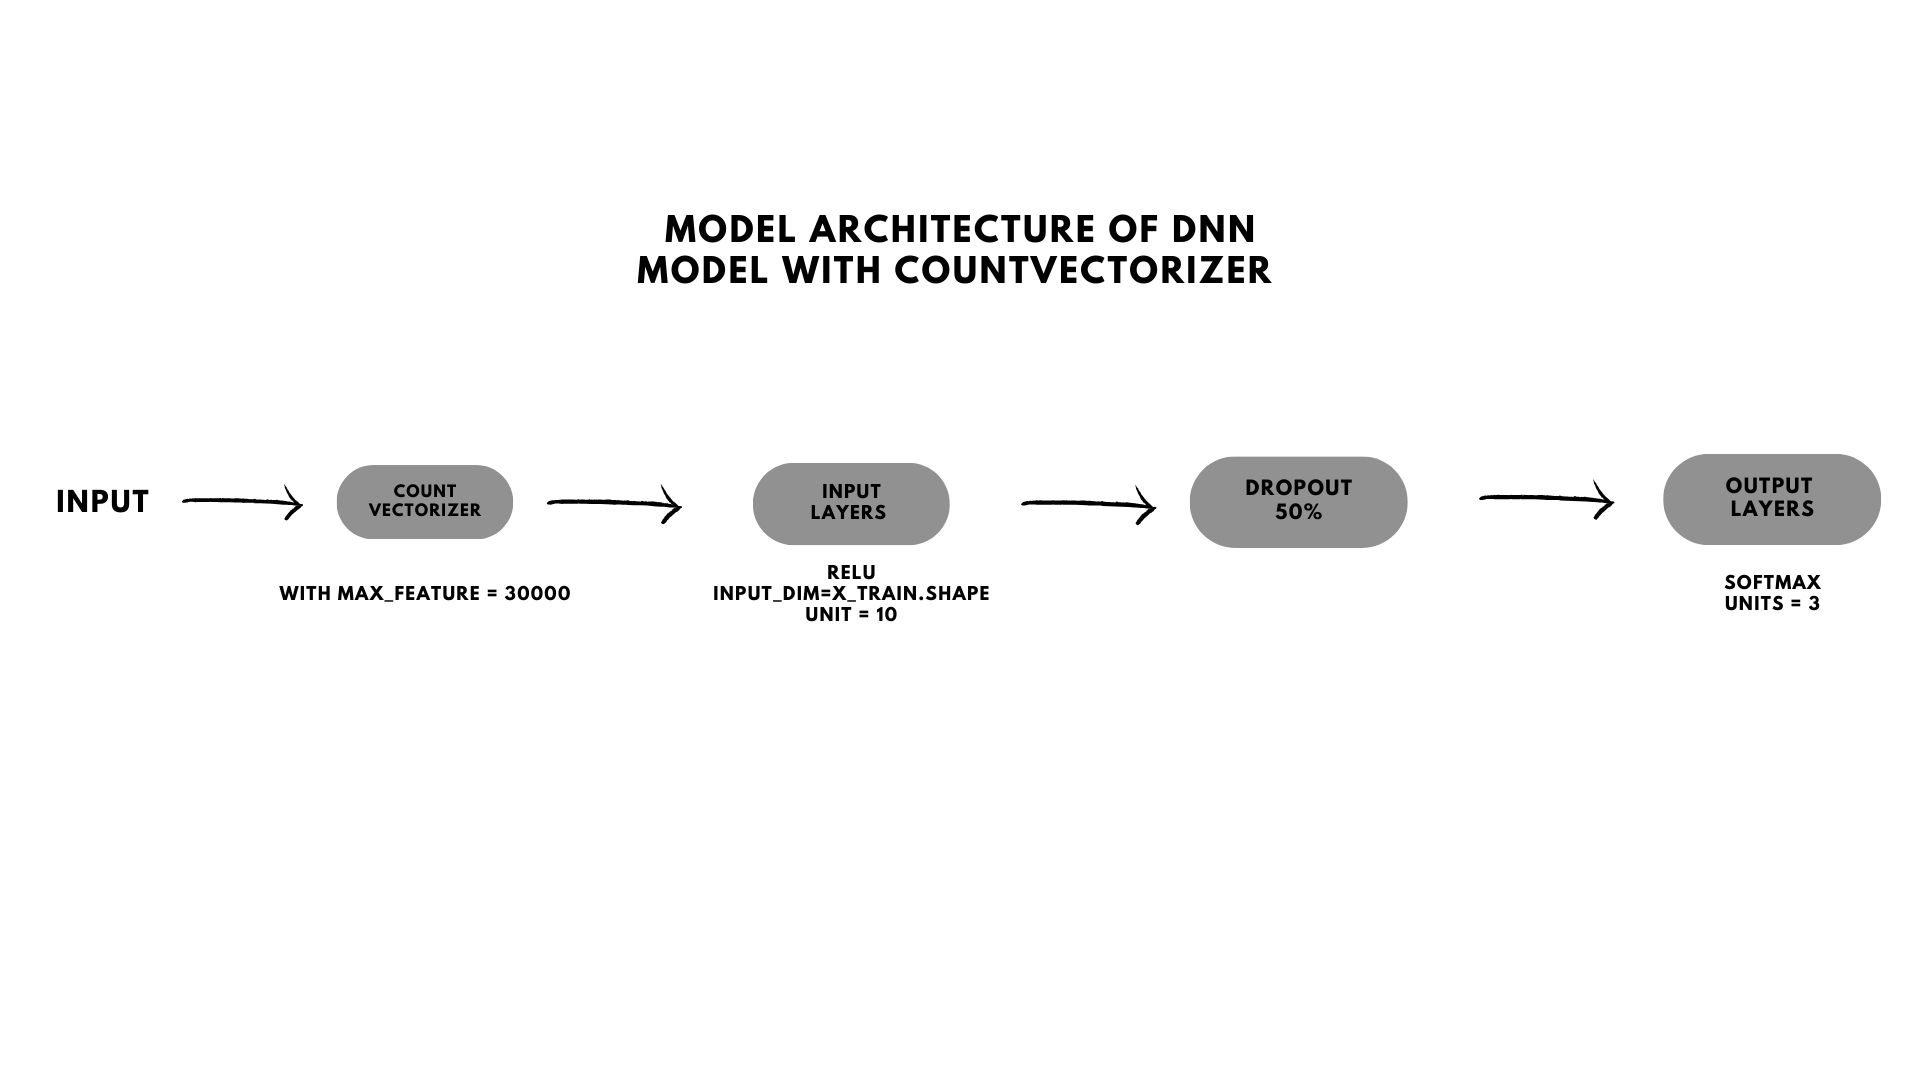

In [15]:
#fuction สำหรับการ insert รูปภาพลง jupyter notebook
import base64
from IPython.display import HTML

image_path = 'COUNTVEC_ARTHI.jpg'

with open(image_path, 'rb') as f:
    image_data = base64.b64encode(f.read()).decode('utf-8')

html_code = f'<img src="data:image/jpeg;base64,{image_data}" width="600" height="350">'

HTML(html_code)

In [16]:
#ใช้ early stop มาช่วยในกรณีถ้าtrainในแต่ละรอบ แล้ว ค่า loss เริ่มเด้งขึ้น โดยจะตัดถ้าloss เริ่มไม่ดีขึ้นหลังจาก train 15 epoch
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

In [17]:
Countmodel = model.fit(
    X_train_cv, y_train_cv,
    epochs=50, # เราจะทำ50 รอบ
    batch_size=10,  #ใช้10 เพื่อให้ train ไม่กินเครื่องมากเกินไป และเป็นการทำ regularization ไปในตัวด้วย
    validation_data=(X_test_cv, y_test_cv),
    callbacks=[early_stopping]  # เพิ่ม early stop
)

Epoch 1/50
3150/3150 [==============================] - 23s 7ms/step - loss: 0.6180 - accuracy: 0.7404 - val_loss: 0.3457 - val_accuracy: 0.8798
Epoch 2/50
3150/3150 [==============================] - 10s 3ms/step - loss: 0.4431 - accuracy: 0.8180 - val_loss: 0.3147 - val_accuracy: 0.8876
Epoch 3/50
3150/3150 [==============================] - 9s 3ms/step - loss: 0.3777 - accuracy: 0.8392 - val_loss: 0.3095 - val_accuracy: 0.8912
Epoch 4/50
3150/3150 [==============================] - 9s 3ms/step - loss: 0.3493 - accuracy: 0.8538 - val_loss: 0.3119 - val_accuracy: 0.8887
Epoch 5/50
3150/3150 [==============================] - 9s 3ms/step - loss: 0.3334 - accuracy: 0.8646 - val_loss: 0.3459 - val_accuracy: 0.8904
Epoch 6/50
3150/3150 [==============================] - 9s 3ms/step - loss: 0.3188 - accuracy: 0.8691 - val_loss: 0.3425 - val_accuracy: 0.8901
Epoch 7/50
3150/3150 [==============================] - 9s 3ms/step - loss: 0.3012 - accuracy: 0.8768 - val_loss: 0.3517 - val_accurac

In [18]:
def plot_history(model): # ฟังก์ชั่นสำหรับใช้ plot graph เช็ค ค่า accuracy และ ค่า loss ของทั้ง val และ train
    acc = model.history['accuracy']
    val_acc = model.history['val_accuracy']
    loss = model.history['loss']
    val_loss = model.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

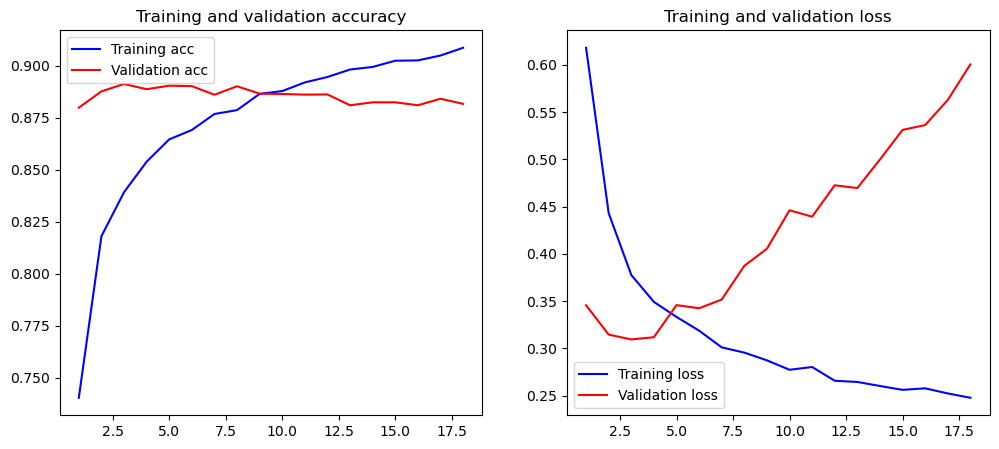

In [19]:
plot_history(Countmodel)

In [20]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score

y_pred = model.predict(X_test_cv)

422/422 [==============================] - 3s 5ms/step


In [21]:
y_pred_classes = np.argmax(y_pred, axis=1)

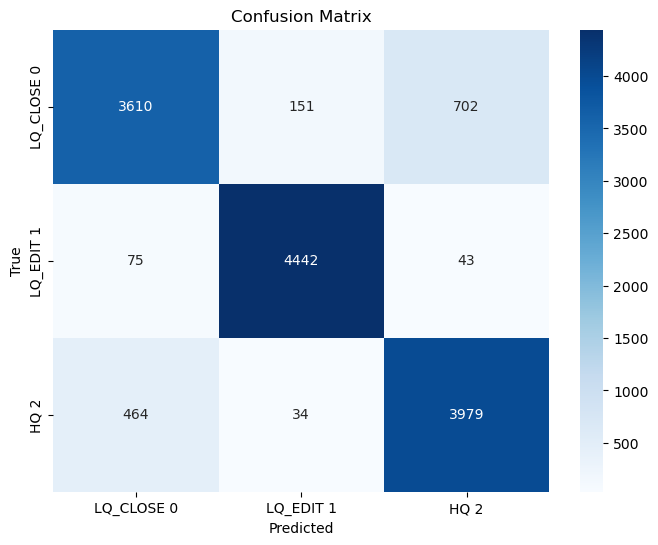

In [22]:
cm = confusion_matrix(y_test_cv, y_pred_classes)

# Plot the confusion matrix using seaborn and matplotlib
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['LQ_CLOSE 0', 'LQ_EDIT 1', 'HQ 2'], yticklabels=['LQ_CLOSE 0', 'LQ_EDIT 1', 'HQ 2'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### สรุป

จากการ train เราจะพบว่า model จะทำการ early stop ตัวเอง เมื่อถึง epoch ที่ 16 เพราะ loss เริ่มสูงมากขึ้น โดยผล accuracy ของ model จะอยู่ที่ประมาณ 0.925 และ accuracy ของ validation จะอยู่ที่ประมาณ 0.875 และมีแนวโน้มต่ำลง ถ้าหากมองไปที่ กราฟทางด้านขวา จะพบว่า model มีความ overfit ค่อนข้างสูง จากการ train ไปเรื่อยๆถ้าเทียบกับ model อื่นๆจะพบว่า model ตัวนี้ ประสิทธิภาพไม่ค่อยดีมากนัก อาจจะเพราะ dimentsion ของข้อมูลเยอะเกินตอนทำ countvectoizer 



### เทียบคะแนนกับ model ตัวอื่นๆ 

DNN with CountVectorizer (ตัวที่แย่ที่สุด)

Train Accuracy : 0.925
Validation Accuracy : 0.875


DNN with Flattern layers and word embeddings (ตัวที่ดีที่สุด อันดับ2)

Training Accuracy: 0.8716
Validation Accuracy: 0.8331


DNN with GlobalMaxpooling layer and word embeddings (ตัวที่ดีที่สุด)

Training Accuracy: 0.8722
Validation Accuracy: 0.8620


DNN with ConVU1d and word embeddings (อันดับ3)

Training Accuracy: 0.8692
Validation Accuracy: 0.8453
